In [1]:
import numpy as np

class Matrix:
    def __init__(self, data, _children=(), _op=''):
        """
        Initialize the Matrix with 2D data, optional children, and operation type.

        Args:
            data (array-like): Input data for the Matrix.
            _children (tuple): Optional tuple of child Matrixs for autograd.
            _op (str): Operation type that created this Matrix.
        """
        if not isinstance(_children, tuple):
            raise TypeError("_children must be a tuple")
        if not isinstance(_op, str):
            raise TypeError("_op must be a string")

        self.data = np.array(data, dtype=np.float32)
        if self.data.ndim == 0:
            self.data = self.data.reshape(1, 1)
        elif self.data.ndim == 1:
            self.data = self.data.reshape(-1, 1)
        assert self.data.ndim == 2, "Input must be a Matrix (1D or 2D Matrix)"


        self.grad = np.zeros_like(self.data, dtype=np.float32)
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self._is_leaf = len(_children) == 0
        self._backward_called = False
        self.shape = self.data.shape

    def __repr__(self, print_grad = False):
        if print_grad:
            return f"Matrix(data=\n{self.data},\n grad=\n{self.grad}\n)"
        return f"Matrix(data=\n{self.data}\n)"


    def __call__(self):
        """
        Return the matrix data.

        Returns:
            numpy.ndarray: The data contained in the matrix.
        """
        return self.data

    def __eq__(self, other):
        """
        Compare this Matrix with another Matrix or array-like object.
        
        Args:
            other (Matrix or array-like): The object to compare with.
        
        Returns:
            bool: True if the data in both objects is equal, False otherwise.
        """
        if isinstance(other, Matrix):
            return np.array_equal(self.data, other.data)
        elif isinstance(other, (np.ndarray, list)):
            return np.array_equal(self.data, np.array(other))
        return False
    
    def __hash__(self):
        return id(self)

    def backward(self, gradient=None):
        """
        Perform backpropagation to compute gradients.

        Args:
            gradient (array-like): Initial gradient to propagate. If None, uses ones.
        """
        if self._backward_called:
            raise RuntimeError("backward() has already been called on this graph.")
        
        if gradient is None:
            gradient = np.ones_like(self.data, dtype=np.float32)
        
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = gradient
        for v in reversed(topo):
            v._backward()

        self._backward_called = True

    def zero_grad(self):
        """Reset the gradients of the Matrix to zero."""
        self.grad = np.zeros_like(self.data, dtype=np.float32)
        self._backward_called = False

    def __add__(self, other):
        """Element-wise addition of two matrices."""
        other = other if isinstance(other, Matrix) else Matrix(other)
        out = Matrix(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out
    
    def __sub__(self, other): 
        """Element-wise substraction of two matrices."""
        other = other if isinstance(other, Matrix) else Matrix(other)
        out = Matrix(self.data - other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad -= out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        """Element-wise multiplication of two Matrix objects.
           or, Hadamard product 
        """
        other = other if isinstance(other, Matrix) else Matrix(other)
        out = Matrix(self.data * other.data, (self, other), '*')

        def _backward():
            grad_self = other.data * out.grad
            grad_other = self.data * out.grad

            self.grad += grad_self
            other.grad += grad_other

        out._backward = _backward
        return out

    def sum(self):
        """Sum all elements of the Matrix and return a scalar Matrix."""
        out = Matrix(np.sum(self.data).reshape(1, 1), (self,), 'sum')

        def _backward():
            self.grad += np.ones_like(self.data) * out.grad

        out._backward = _backward
        return out
    
    def relu(self):
        """Apply the ReLU activation function element-wise."""
        out = Matrix(np.maximum(0, self.data), (self,), 'ReLU')
        out._op = 'ReLU'

        def _backward():
            self.grad += (out.data > 0) * out.grad

        out._backward = _backward
        return out
    
    def matmul(self, other):
        """Perform matrix multiplication."""
        other = other if isinstance(other, Matrix) else Matrix(other)
        assert self.data.shape[1] == other.data.shape[0], "Inner dimensions must match for matrix multiplication"

        out = Matrix(np.matmul(self.data, other.data), (self, other), 'matmul')

        def _backward():
            self.grad += np.matmul(out.grad, other.data.T)
            other.grad += np.matmul(self.data.T, out.grad)
        out._backward = _backward

        return out

    def __pow__(self, other):
        """Raise the Matrix elements to the power of other."""
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Matrix(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad

        out._backward = _backward
        return out

    def transpose(self):
        """Transpose the last two dimensions of the Matrix."""
        out = Matrix(self.data.T, (self,), 'transpose')

        def _backward():
            self.grad += out.grad.T
        out._backward = _backward

        return out

    @property
    def T(self):
        """Shortcut for transpose method."""
        return self.transpose()

    def __neg__(self): 
        """Element-wise negation of the Matrix."""
        return self * -1

    def __truediv__(self, other): 
        """Element-wise division of two Matrix objects with broadcasting support."""
        return self * other**-1

    def __radd__(self, other): 
        """Right-hand side addition for scalar + Matrix."""
        return self + other

    def __rsub__(self, other): 
        """Right-hand side subtraction for scalar - Matrix."""
        return other + (-self)

    def __rmul__(self, other): 
        """Right-hand side multiplication for scalar * Matrix."""
        return self * other

    def __rtruediv__(self, other): 
        """Right-hand side division for scalar / Matrix."""
        return other * self**-1


In [2]:

class Layer:
    def __init__(self, in_features, out_features):
        # Transpose the weight matrix to handle column vector inputs
        self.weight = Matrix(np.random.randn(out_features, in_features) * np.sqrt(2.0 / in_features))
        self.bias = Matrix(np.zeros((out_features, 1)))

    def __call__(self, x):
        if not isinstance(x, Matrix):
            x = Matrix(x)
        # Use matrix multiplication without transposing
        return self.weight.matmul(x) + self.bias

    def parameters(self):
        return [self.weight, self.bias]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = x.relu()
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

petitgrad Epoch 0, Loss: 1.3539
petitgrad Epoch 100, Loss: 0.7392
petitgrad Epoch 200, Loss: 0.7372
petitgrad Epoch 300, Loss: 0.7365
petitgrad Epoch 400, Loss: 0.7352
petitgrad Epoch 500, Loss: 0.7357
petitgrad Epoch 600, Loss: 0.7349
petitgrad Epoch 700, Loss: 0.7351
petitgrad Epoch 800, Loss: 0.7345
petitgrad Epoch 900, Loss: 0.7343


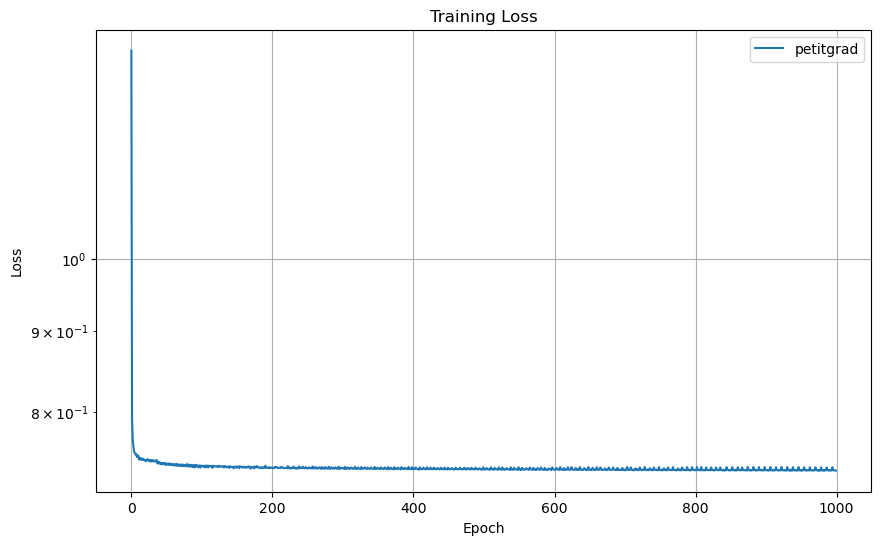

petitgrad training time: 26.40 seconds


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Generate some random data
np.random.seed(42)
num_samples = 100
input_size = 3
output_size = 1

X = np.random.randn(input_size, num_samples)
Y = np.random.randn(output_size, num_samples)

# Initialize model
nin, nouts = input_size, [4, 4, output_size]
petitgrad_mlp = MLP(nin, nouts)

# Training loop for petitgrad model
def train_step_petitgrad(model, x, y, learning_rate):
    # Zero gradients
    for param in model.parameters():
        param.zero_grad()
    # Forward pass
    y_pred = model(x)
    loss = ((y_pred - y)**2).sum()
    # Backward pass
    loss.backward()
    # Update parameters
    for param in model.parameters():
        param.data -= learning_rate * param.grad
    return loss.data.item()

# Training
epochs = 1000
learning_rate = 0.01
petitgrad_losses = []

# Training petitgrad model
start_time = time.time()
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(num_samples):
        x = Matrix(X[:, i]) # Already a column vector
        y = Matrix(Y[:, i])  # Already a column vector
        epoch_loss += train_step_petitgrad(petitgrad_mlp, x, y, learning_rate)
    avg_loss = epoch_loss / num_samples
    petitgrad_losses.append(avg_loss)
    if epoch % 100 == 0:
        print(f"petitgrad Epoch {epoch}, Loss: {avg_loss:.4f}")
petitgrad_time = time.time() - start_time

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(petitgrad_losses, label='petitgrad')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Print training time
print(f"petitgrad training time: {petitgrad_time:.2f} seconds")

petitgrad Epoch 100, Loss: 0.6356
petitgrad Epoch 200, Loss: 0.6355
petitgrad Epoch 300, Loss: 0.6306
petitgrad Epoch 400, Loss: 0.6279
petitgrad Epoch 500, Loss: 0.6311
petitgrad Epoch 600, Loss: 0.6308
petitgrad Epoch 700, Loss: 0.6289
petitgrad Epoch 800, Loss: 0.6283
petitgrad Epoch 900, Loss: 0.6301
Micrograd Epoch 100, Loss: 0.7621
Micrograd Epoch 200, Loss: 0.7429
Micrograd Epoch 300, Loss: 0.7320
Micrograd Epoch 400, Loss: 0.7232
Micrograd Epoch 500, Loss: 0.7155
Micrograd Epoch 600, Loss: 0.7096
Micrograd Epoch 700, Loss: 0.7042
Micrograd Epoch 800, Loss: 0.7000
Micrograd Epoch 900, Loss: 0.6931
Micrograd Epoch 1000, Loss: 0.6859


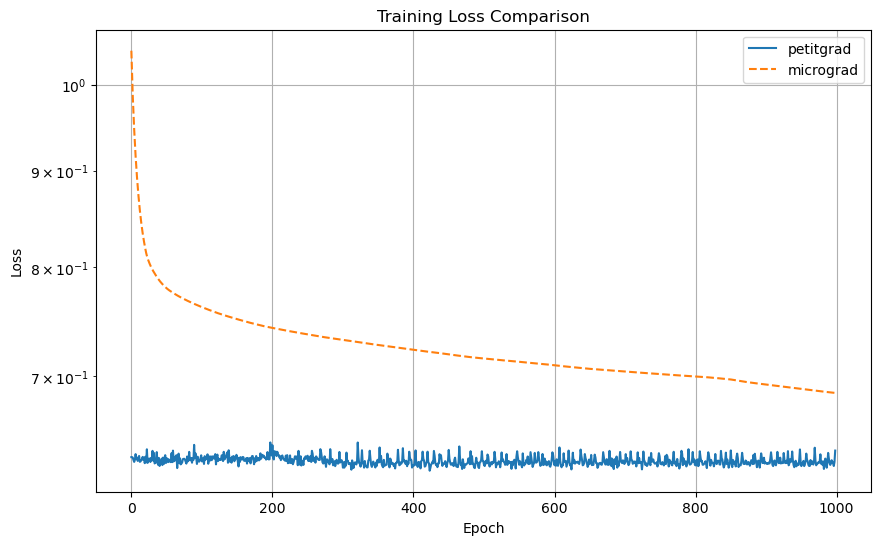

micrograd training time: 76.22 seconds
petitgrad training time: 23.64 seconds


In [7]:
import numpy as np
from micrograd.engine import Value
from micrograd.nn import MLP as MicrogradMLP
import matplotlib.pyplot as plt
import time

# Generate some random data
np.random.seed(42)
x_data = np.random.randn(100, 3)
y_data = np.random.randn(100, 1)

# Convert data to micrograd Values
def array_to_value(arr):
    return [[Value(x) for x in row] for row in arr]

x_micrograd = array_to_value(x_data)
y_micrograd = array_to_value(y_data)

# Initialize models
nin, nouts = 3, [4, 4, 1]
micrograd_mlp = MicrogradMLP(nin, nouts)

# Training loop for petitgrad model
def train_step_petitgrad(model, x, y, learning_rate):
    for param in model.parameters():
        param.zero_grad()
    # Forward pass
    y_pred = model(x)
    loss = ((y_pred - y)**2).sum()
    # Backward pass
    loss.backward()
    # Update parameters
    for param in model.parameters():
        param.data -= learning_rate * param.grad
    return loss.data.item()

# Training loop for Micrograd
def train_step_micrograd(model, x, y, learning_rate):
    # Forward pass
    y_pred = [model(row) for row in x]
    loss = sum((pred - target[0])**2 for pred, target in zip(y_pred, y)) / len(y)
    # Backward pass
    model.zero_grad()
    loss.backward()
    # Update parameters
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    return loss.data

# Training Micrograd Model
epochs = 1000
learning_rate_micrograd = 0.01
learning_rate_petitgrad = 0.01

# Initialize petitgrad model
petitgrad_mlp = MLP(nin, nouts)

# Convert data to petitgrad Matrix (as column vectors)
x_petitgrad = [Matrix(x.reshape(-1, 1)) for x in x_data]
y_petitgrad = [Matrix(y.reshape(-1, 1)) for y in y_data]


# Training petitgrad model
petitgrad_losses = []
start_time = time.time()
for epoch in range(1,epochs):
    epoch_loss = 0
    for x, y in zip(x_petitgrad, y_petitgrad):
        epoch_loss += train_step_petitgrad(petitgrad_mlp, x, y, learning_rate_petitgrad)
    avg_loss = epoch_loss / len(x_petitgrad)
    petitgrad_losses.append(avg_loss)
    if epoch % 100 == 0 or epoch == epochs:
        print(f"petitgrad Epoch {epoch}, Loss: {avg_loss:.4f}")
petitgrad_time = time.time() - start_time



micrograd_losses = []
start_time = time.time()
for epoch in range(1,epochs+1):
    micrograd_loss = train_step_micrograd(micrograd_mlp, x_micrograd, y_micrograd, learning_rate_micrograd)
    micrograd_losses.append(micrograd_loss)
    if epoch % 100 == 0 or epoch == epochs:
        print(f"Micrograd Epoch {epoch}, Loss: {micrograd_loss:.4f}")
micrograd_time = time.time() - start_time

# Plot loss comparison
plt.figure(figsize=(10, 6))
plt.plot(petitgrad_losses, label='petitgrad')
plt.plot(micrograd_losses, label='micrograd', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Print training times
print(f"micrograd training time: {micrograd_time:.2f} seconds")
print(f"petitgrad training time: {petitgrad_time:.2f} seconds")